In [41]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Define Process class
class Process:
    def __init__(self, pid, arrival_time, burst_time, priority=5):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.priority = priority
        self.completion_time = 0
        self.turnaround_time = 0
        self.waiting_time = 0
        self.remaining_time = burst_time

# FCFS Scheduling Function
def fcfs_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    for process in processes:
        if current_time < process.arrival_time:
            current_time = process.arrival_time
        process.waiting_time = current_time - process.arrival_time
        process.completion_time = current_time + process.burst_time
        process.turnaround_time = process.burst_time + process.waiting_time
        current_time += process.burst_time
        total_waiting_time += process.waiting_time
        total_turnaround_time += process.turnaround_time
    return total_waiting_time / len(processes), total_turnaround_time / len(processes)

# SJF Scheduling Function
def sjf_scheduling(processes):
    processes.sort(key=lambda x: (x.arrival_time, x.burst_time))
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    completed = 0
    n = len(processes)
    ready_queue = []
    while completed < n:
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.burst_time)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            current_process.waiting_time = current_time - current_process.arrival_time
            current_process.completion_time = current_time + current_process.burst_time
            current_process.turnaround_time = current_process.burst_time + current_process.waiting_time
            current_time += current_process.burst_time
            completed += 1
            total_waiting_time += current_process.waiting_time
            total_turnaround_time += current_process.turnaround_time
        else:
            current_time += 1
    return total_waiting_time / n, total_turnaround_time / n

# Round Robin Scheduling Function
def round_robin_scheduling(processes, time_quantum=4):
    current_time = 0
    queue = processes[:]
    for process in queue:
        process.remaining_time = process.burst_time
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(processes)
    while queue:
        process = queue.pop(0)
        if process.remaining_time <= time_quantum:
            current_time += process.remaining_time
            process.waiting_time = current_time - process.arrival_time - process.burst_time
            process.turnaround_time = current_time - process.arrival_time
            total_waiting_time += process.waiting_time
            total_turnaround_time += process.turnaround_time
        else:
            current_time += time_quantum
            process.remaining_time -= time_quantum
            queue.append(process)
    return total_waiting_time / n, total_turnaround_time / n

# Preemptive Priority Scheduling Function
def priority_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    n = len(processes)
    total_waiting_time = 0
    total_turnaround_time = 0
    ready_queue = []

    while completed < n:
        # Add processes that have arrived to the ready queue
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)

        # Sort ready queue by priority, then by arrival time to pick the highest-priority process
        if ready_queue:
            ready_queue.sort(key=lambda x: (x.priority, x.arrival_time))
            current_process = ready_queue[0]

            # Process current task for one time unit
            current_time += 1
            current_process.remaining_time -= 1

            # If the process finishes, record times and remove it from the ready queue
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                total_waiting_time += current_process.waiting_time
                total_turnaround_time += current_process.turnaround_time
                completed += 1
                ready_queue.pop(0)  # Remove completed process from queue
        else:
            # If no processes are ready, advance time
            current_time += 1

    return total_waiting_time / n, total_turnaround_time / n


# Multilevel Queue Scheduling Function
def multilevel_queue_scheduling(processes, time_quantum=4):
    high_priority = [p for p in processes if p.priority <= 3]
    low_priority = [p for p in processes if p.priority > 3]
    total_waiting_time, total_turnaround_time = 0, 0
    n = len(processes)
    if high_priority:
        rr_wait, rr_turnaround = round_robin_scheduling(high_priority, time_quantum)
        total_waiting_time += rr_wait * len(high_priority)
        total_turnaround_time += rr_turnaround * len(high_priority)
    if low_priority:
        fcfs_wait, fcfs_turnaround = fcfs_scheduling(low_priority)
        total_waiting_time += fcfs_wait * len(low_priority)
        total_turnaround_time += fcfs_turnaround * len(low_priority)
    return total_waiting_time / n, total_turnaround_time / n

# Multilevel Feedback Queue Scheduling Function
def multilevel_feedback_queue_scheduling(processes, time_quantum=4, num_queues=3):
    queues = [[] for _ in range(num_queues)]
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(processes)
    for process in processes:
        process.remaining_time = process.burst_time
        queues[0].append(process)
    for i in range(num_queues):
        while queues[i]:
            process = queues[i].pop(0)
            quantum = time_quantum * (2 ** i)
            if process.remaining_time > quantum:
                current_time += quantum
                process.remaining_time -= quantum
                if i < num_queues - 1:
                    queues[i + 1].append(process)
                else:
                    queues[i].append(process)
            else:
                current_time += process.remaining_time
                process.waiting_time = current_time - process.arrival_time - process.burst_time
                process.turnaround_time = current_time - process.arrival_time
                total_waiting_time += process.waiting_time
                total_turnaround_time += process.turnaround_time
    return total_waiting_time / n, total_turnaround_time / n

# Update process generation to include random priority
def generate_random_processes(num_processes):
    return [Process(pid=i+1, arrival_time=random.randint(0, 10), burst_time=random.randint(1, 10), priority=random.randint(1, 5)) for i in range(num_processes)]

# Run simulations
def run_large_scale_simulation(num_simulations=1000, num_processes=10, time_quantum=4):
    fcfs_waiting_times = np.zeros(num_simulations)
    fcfs_turnaround_times = np.zeros(num_simulations)
    sjf_waiting_times = np.zeros(num_simulations)
    sjf_turnaround_times = np.zeros(num_simulations)
    rr_waiting_times = np.zeros(num_simulations)
    rr_turnaround_times = np.zeros(num_simulations)
    priority_waiting_times = np.zeros(num_simulations)
    priority_turnaround_times = np.zeros(num_simulations)
    mlq_waiting_times = np.zeros(num_simulations)
    mlq_turnaround_times = np.zeros(num_simulations)
    mlfq_waiting_times = np.zeros(num_simulations)
    mlfq_turnaround_times = np.zeros(num_simulations)

    for i in range(num_simulations):
        processes = generate_random_processes(num_processes)

        fcfs_avg_waiting, fcfs_avg_turnaround = fcfs_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes])
        fcfs_waiting_times[i] = fcfs_avg_waiting
        fcfs_turnaround_times[i] = fcfs_avg_turnaround

        sjf_avg_waiting, sjf_avg_turnaround = sjf_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes])
        sjf_waiting_times[i] = sjf_avg_waiting
        sjf_turnaround_times[i] = sjf_avg_turnaround

        rr_avg_waiting, rr_avg_turnaround = round_robin_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes], time_quantum)
        rr_waiting_times[i] = rr_avg_waiting
        rr_turnaround_times[i] = rr_avg_turnaround

        priority_avg_waiting, priority_avg_turnaround = priority_scheduling([Process(p.pid, p.arrival_time, p.burst_time, random.randint(1, 5)) for p in processes])
        priority_waiting_times[i] = priority_avg_waiting
        priority_turnaround_times[i] = priority_avg_turnaround

        mlq_avg_waiting, mlq_avg_turnaround = multilevel_queue_scheduling([Process(p.pid, p.arrival_time, p.burst_time, random.randint(1, 5)) for p in processes], time_quantum)
        mlq_waiting_times[i] = mlq_avg_waiting
        mlq_turnaround_times[i] = mlq_avg_turnaround

        mlfq_avg_waiting, mlfq_avg_turnaround = multilevel_feedback_queue_scheduling([Process(p.pid, p.arrival_time, p.burst_time) for p in processes], time_quantum)
        mlfq_waiting_times[i] = mlfq_avg_waiting
        mlfq_turnaround_times[i] = mlfq_avg_turnaround

    return (fcfs_waiting_times, fcfs_turnaround_times, sjf_waiting_times, sjf_turnaround_times,
            rr_waiting_times, rr_turnaround_times, priority_waiting_times, priority_turnaround_times,
            mlq_waiting_times, mlq_turnaround_times, mlfq_waiting_times, mlfq_turnaround_times)

def visualize_large_scale_results_with_solid_averages(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
                                                      rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
                                                      mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround):

    # Store data in dictionaries for easier lookup
    waiting_times_dict = {
        "FCFS": fcfs_waiting,
        "SJF": sjf_waiting,
        "Round Robin": rr_waiting,
        "Priority": priority_waiting,
        "MLQ": mlq_waiting,
        "MLFQ": mlfq_waiting
    }
    
    turnaround_times_dict = {
        "FCFS": fcfs_turnaround,
        "SJF": sjf_turnaround,
        "Round Robin": rr_turnaround,
        "Priority": priority_turnaround,
        "MLQ": mlq_turnaround,
        "MLFQ": mlfq_turnaround
    }

    # Color palette
    colors = {
        "FCFS": "#1f77b4",       # Blue
        "SJF": "#ff7f0e",        # Orange
        "Round Robin": "#2ca02c", # Green
        "Priority": "#d62728",   # Red
        "MLQ": "#9467bd",        # Purple
        "MLFQ": "#8c564b"        # Brownish
    }

    # Calculate overall averages
    overall_averages = {
        algo: [np.mean(waiting_times_dict[algo]), np.mean(turnaround_times_dict[algo])]
        for algo in waiting_times_dict.keys()
    }

    # Line chart for Waiting Time
    plt.figure(figsize=(18, 24))
    plt.subplot(3, 1, 1)
    for algo, color in colors.items():
        plt.plot(waiting_times_dict[algo], label=algo, color=color, alpha=0.4)
        plt.axhline(y=overall_averages[algo][0], color=color, linestyle="-")
        plt.text(len(waiting_times_dict[algo]) - 1, overall_averages[algo][0], 
                 f"{overall_averages[algo][0]:.2f} ms", color=color, ha="left", fontsize=9, bbox=dict(facecolor="white", edgecolor="black"))
    plt.xlabel("Simulation #")
    plt.ylabel("Average Waiting Time (ms)")
    plt.title("Average Waiting Time per Simulation")
    plt.legend()

    # Line chart for Turnaround Time
    plt.subplot(3, 1, 2)
    for algo, color in colors.items():
        plt.plot(turnaround_times_dict[algo], label=algo, color=color, alpha=0.4)
        plt.axhline(y=overall_averages[algo][1], color=color, linestyle="-")
        plt.text(len(turnaround_times_dict[algo]) - 1, overall_averages[algo][1], 
                 f"{overall_averages[algo][1]:.2f} ms", color=color, ha="left", fontsize=9, bbox=dict(facecolor="white", edgecolor="black"))
    plt.xlabel("Simulation #")
    plt.ylabel("Average Turnaround Time (ms)")
    plt.title("Average Turnaround Time per Simulation")
    plt.legend()

    # Bar chart for overall averages with data labels
    plt.subplot(3, 1, 3)
    labels = list(overall_averages.keys())
    waiting_times = [overall_averages[algo][0] for algo in labels]
    turnaround_times = [overall_averages[algo][1] for algo in labels]
    bar_width = 0.35
    index = np.arange(len(labels))
    plt.bar(index, waiting_times, bar_width, label="Average Waiting Time")
    plt.bar(index + bar_width, turnaround_times, bar_width, label="Average Turnaround Time")
    plt.xlabel("Scheduling Algorithms")
    plt.ylabel("Average Time (ms)")
    plt.title("Overall Average Waiting and Turnaround Times")
    plt.xticks(index + bar_width / 2, labels)

    # Adding data labels above each bar
    for i, v in enumerate(waiting_times):
        plt.text(i, v + 0.1, f"{v:.2f} ms", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(turnaround_times):
        plt.text(i + bar_width, v + 0.1, f"{v:.2f} ms", ha="center", va="bottom", fontsize=9)

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Create summary DataFrame with rounding
    summary_data = {
        "Algorithm": labels,
        "Average Waiting Time (ms)": [round(value, 2) for value in waiting_times],
        "Average Turnaround Time (ms)": [round(value, 2) for value in turnaround_times]
    }
    summary_df = pd.DataFrame(summary_data)

    # Display the summary table in a beautiful format
    print("\nSummary of Average Waiting and Turnaround Times:")
    print(summary_df.to_markdown(index=False, tablefmt="grid"))



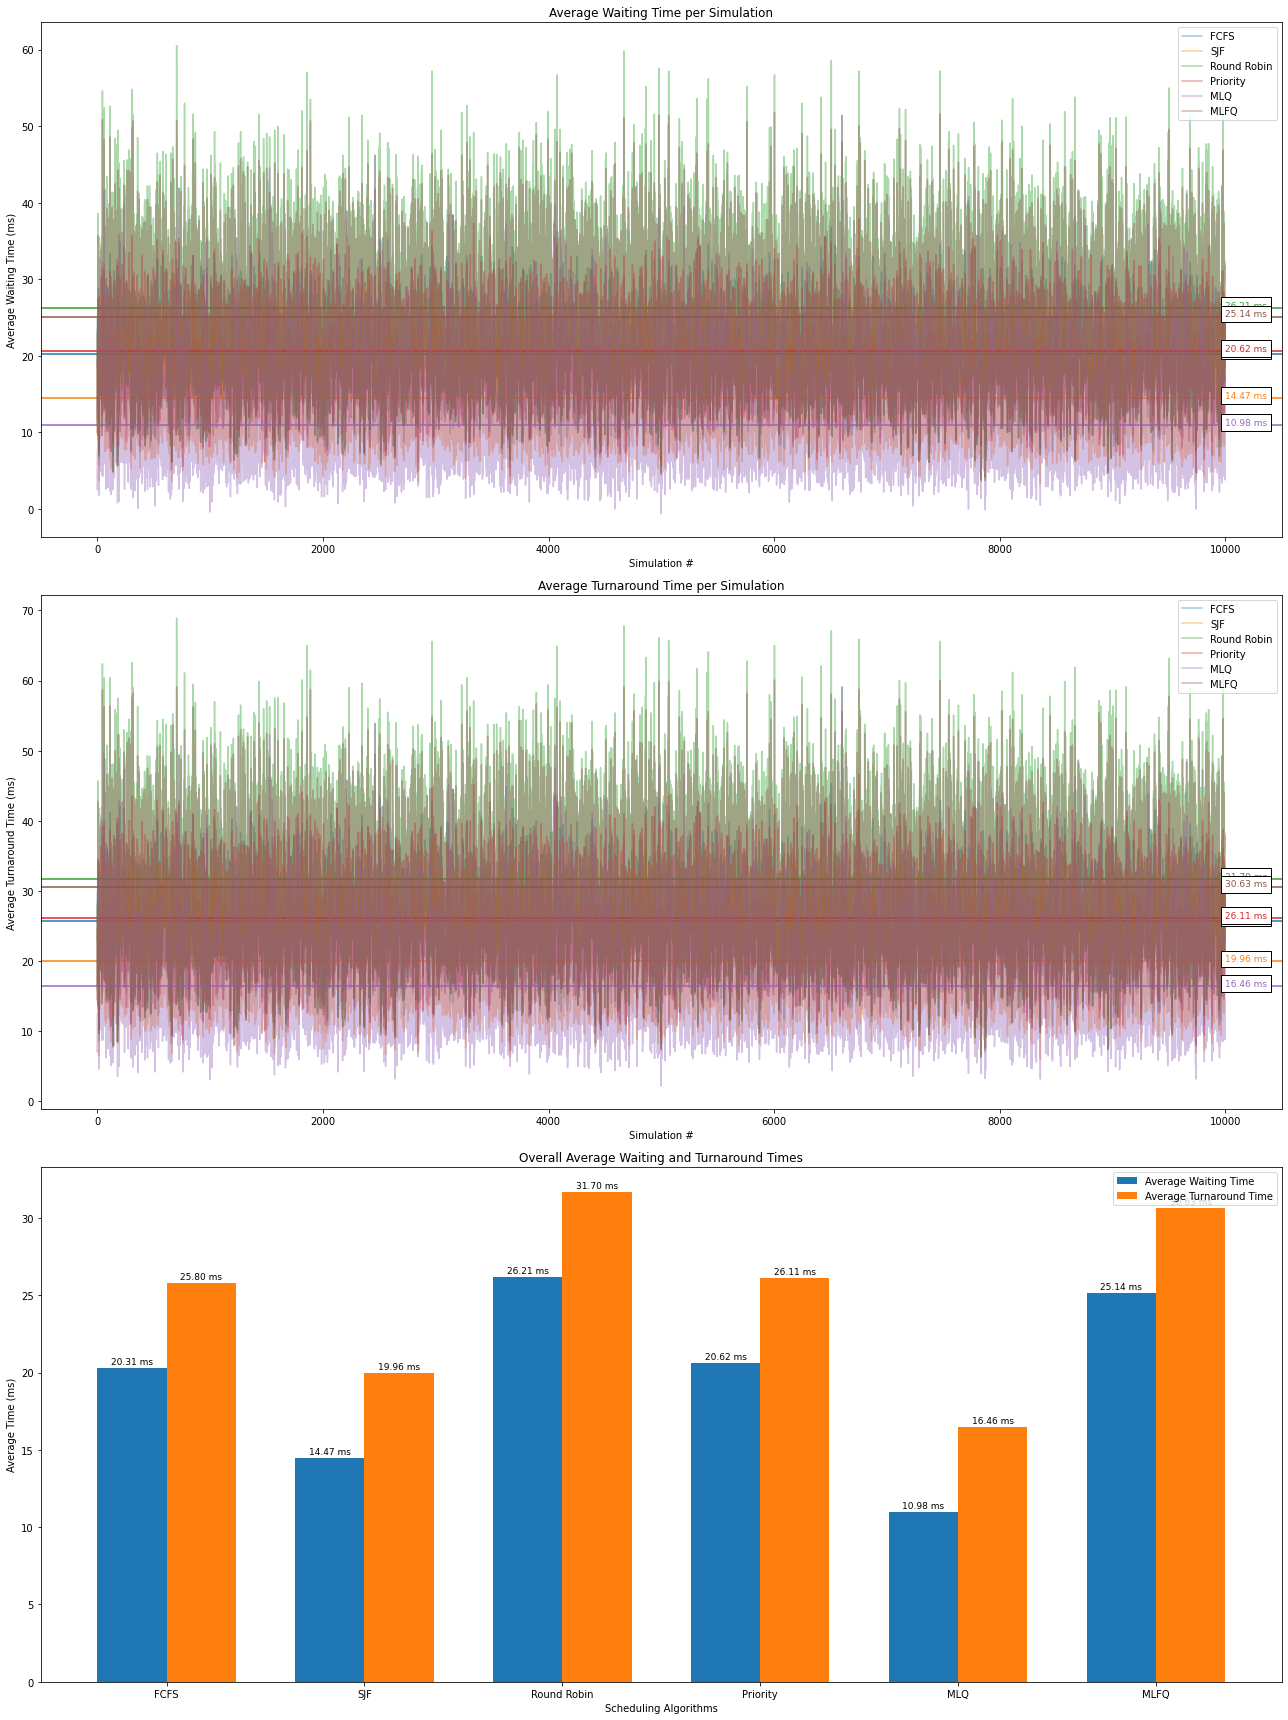


Summary of Average Waiting and Turnaround Times:
+-------------+-----------------------------+--------------------------------+
| Algorithm   |   Average Waiting Time (ms) |   Average Turnaround Time (ms) |
+=============+=============================+================================+
| FCFS        |                       20.31 |                          25.8  |
+-------------+-----------------------------+--------------------------------+
| SJF         |                       14.47 |                          19.96 |
+-------------+-----------------------------+--------------------------------+
| Round Robin |                       26.21 |                          31.7  |
+-------------+-----------------------------+--------------------------------+
| Priority    |                       20.62 |                          26.11 |
+-------------+-----------------------------+--------------------------------+
| MLQ         |                       10.98 |                          16.46 |
+-

In [42]:
# Run simulation and visualize results: 10 Processes
if __name__ == "__main__":
    # Run the large scale simulation
    results = run_large_scale_simulation(num_simulations=10000, num_processes=10, time_quantum=4)

    # Unpack the results
    (fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
     rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
     mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround) = results

    # Visualize the results
    visualize_large_scale_results_with_solid_averages(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
                                                      rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
                                                      mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround)
     
     

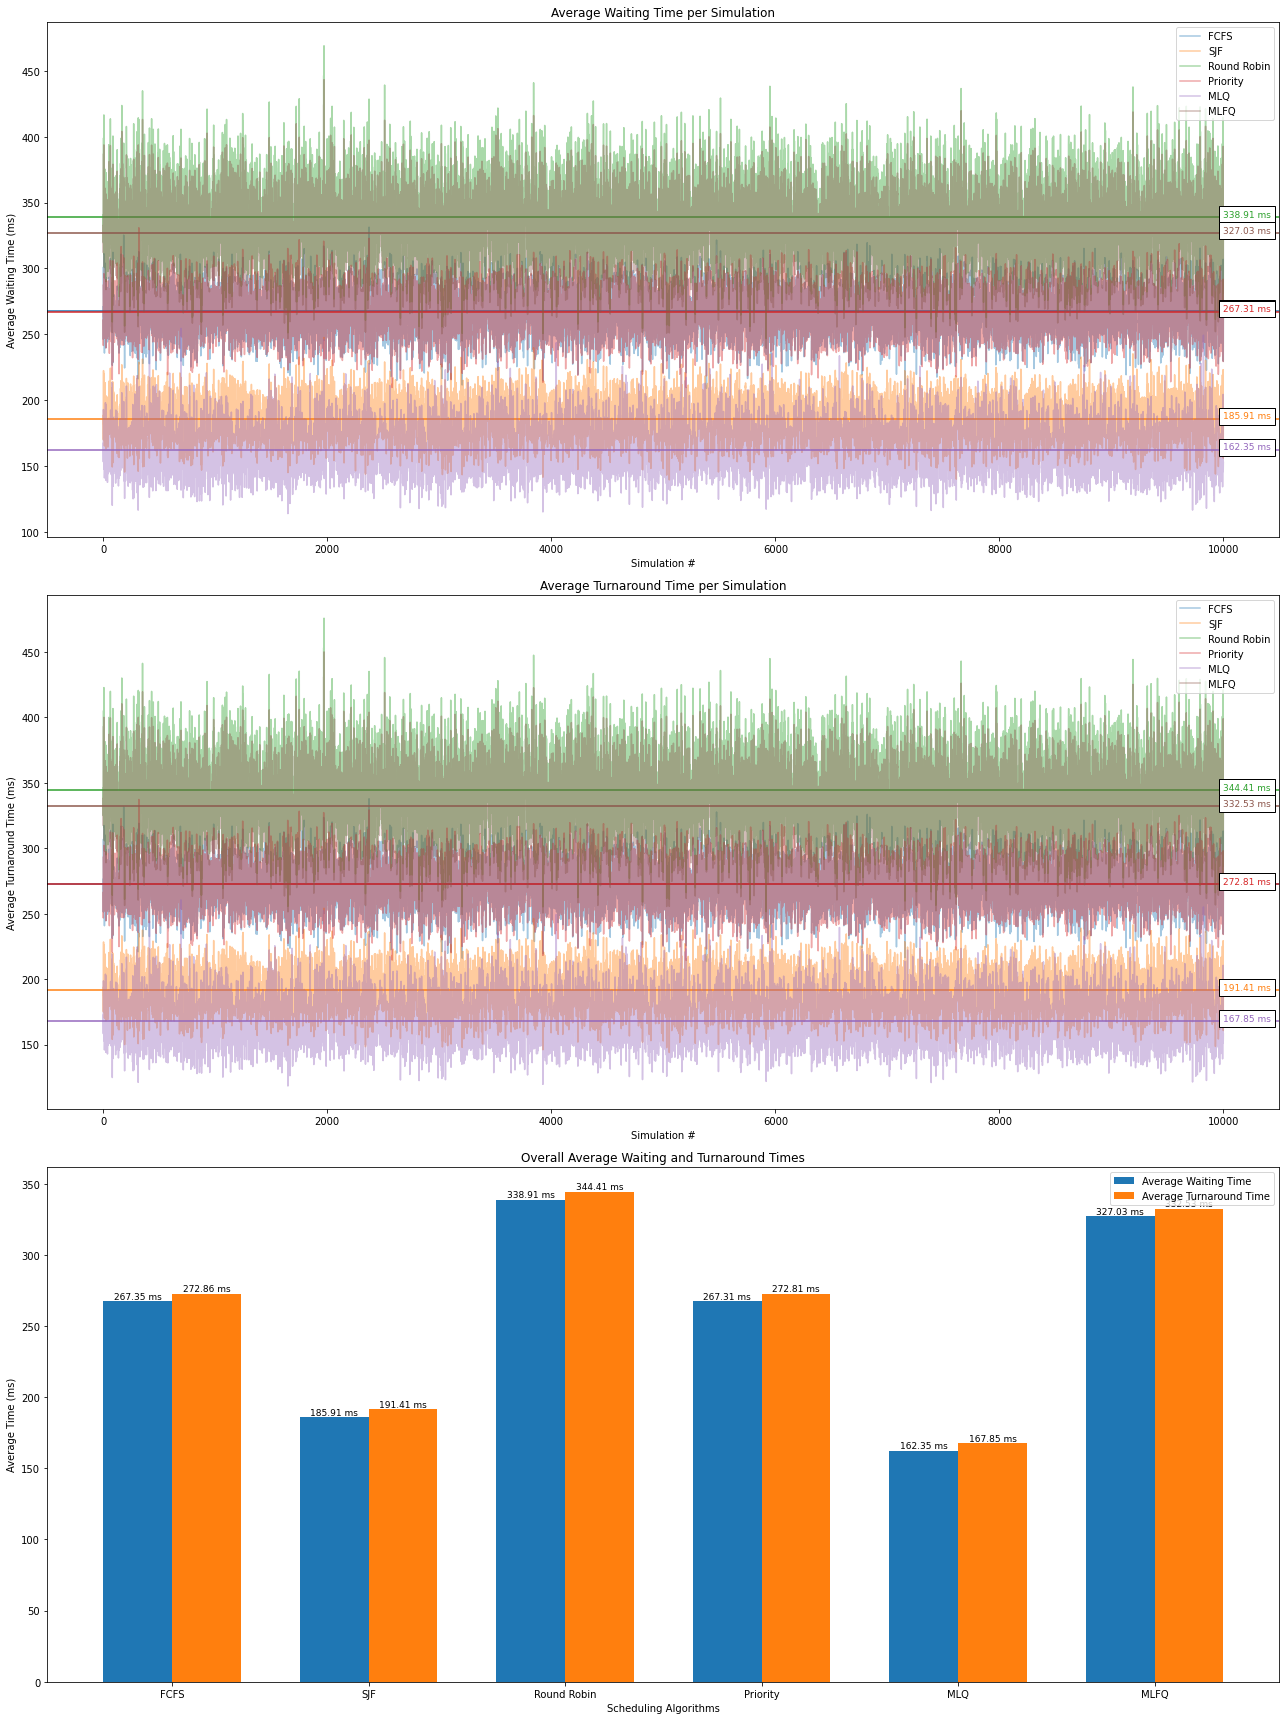


Summary of Average Waiting and Turnaround Times:
+-------------+-----------------------------+--------------------------------+
| Algorithm   |   Average Waiting Time (ms) |   Average Turnaround Time (ms) |
+=============+=============================+================================+
| FCFS        |                      267.35 |                         272.86 |
+-------------+-----------------------------+--------------------------------+
| SJF         |                      185.91 |                         191.41 |
+-------------+-----------------------------+--------------------------------+
| Round Robin |                      338.91 |                         344.41 |
+-------------+-----------------------------+--------------------------------+
| Priority    |                      267.31 |                         272.81 |
+-------------+-----------------------------+--------------------------------+
| MLQ         |                      162.35 |                         167.85 |
+-

In [43]:
# Run simulation and visualize results: 100 Processes
if __name__ == "__main__":
    # Run the large scale simulation
    results = run_large_scale_simulation(num_simulations=10000, num_processes=100, time_quantum=4)

    # Unpack the results
    (fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
     rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
     mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround) = results

    # Visualize the results
    visualize_large_scale_results_with_solid_averages(fcfs_waiting, fcfs_turnaround, sjf_waiting, sjf_turnaround,
                                                      rr_waiting, rr_turnaround, priority_waiting, priority_turnaround,
                                                      mlq_waiting, mlq_turnaround, mlfq_waiting, mlfq_turnaround)
     

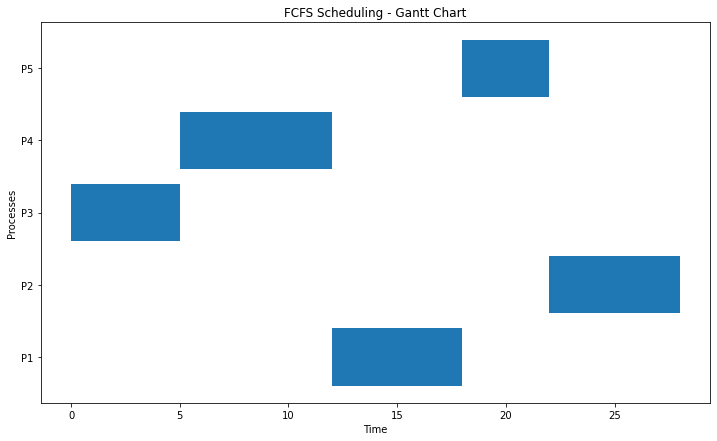

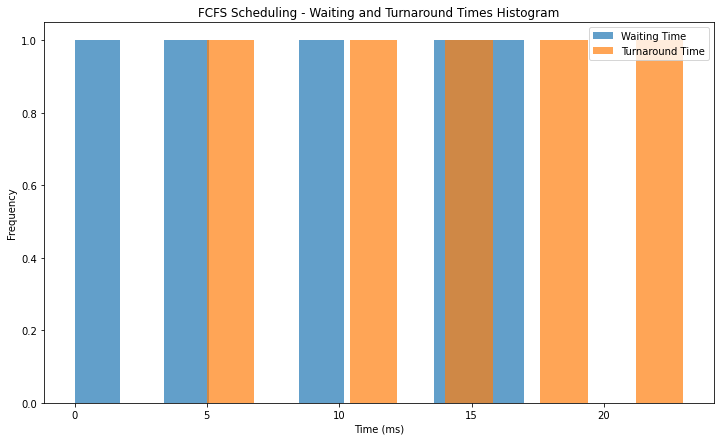

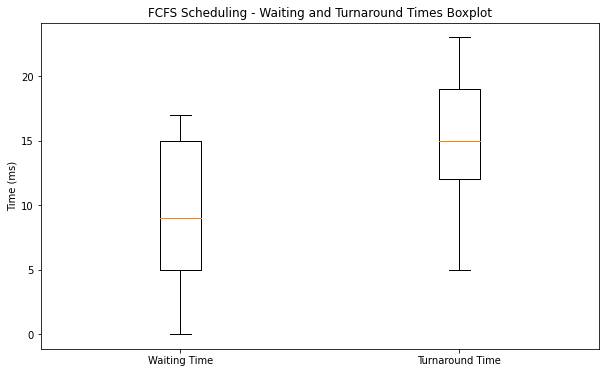

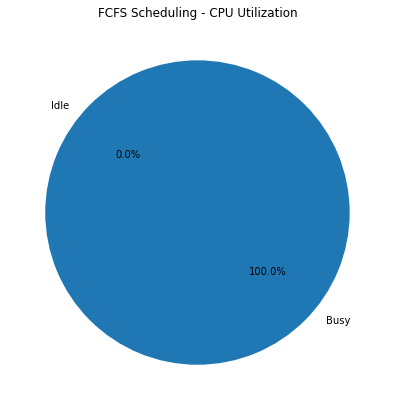

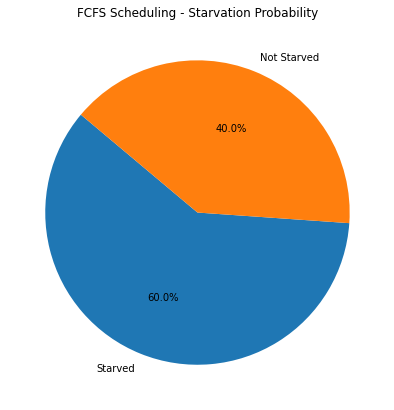

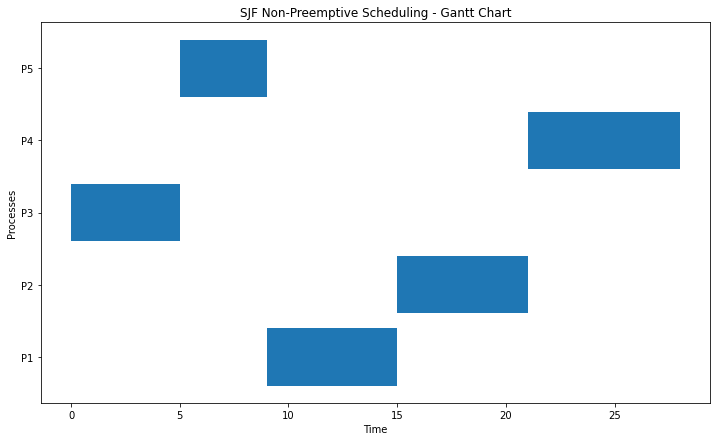

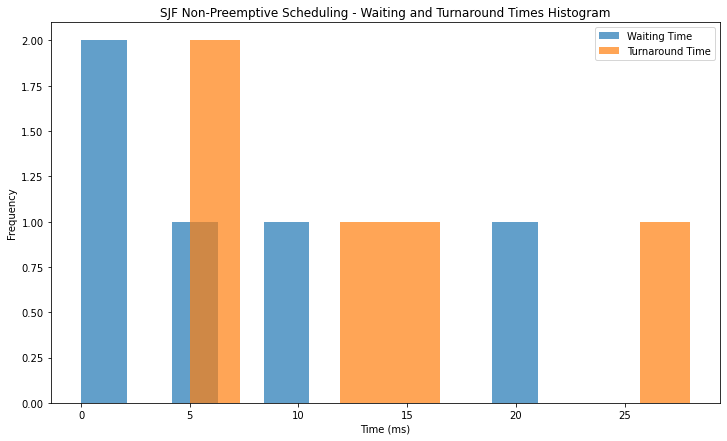

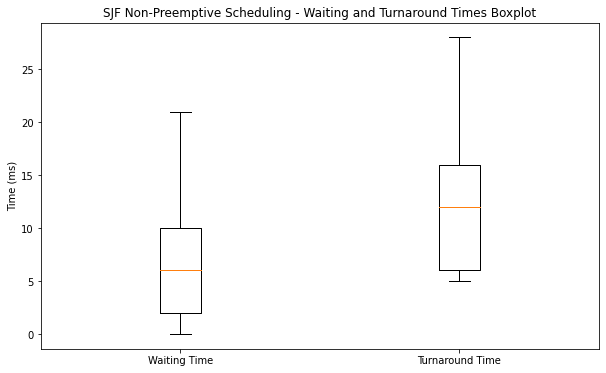

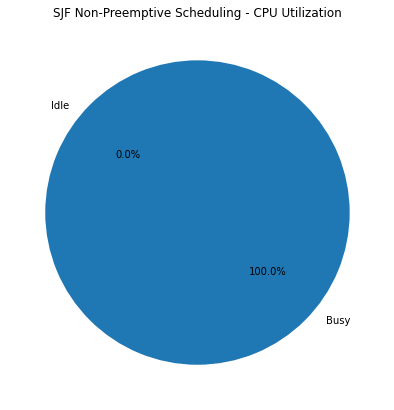

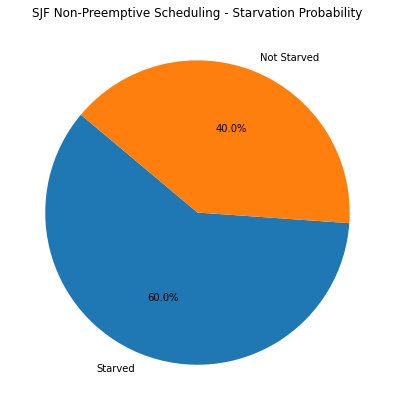

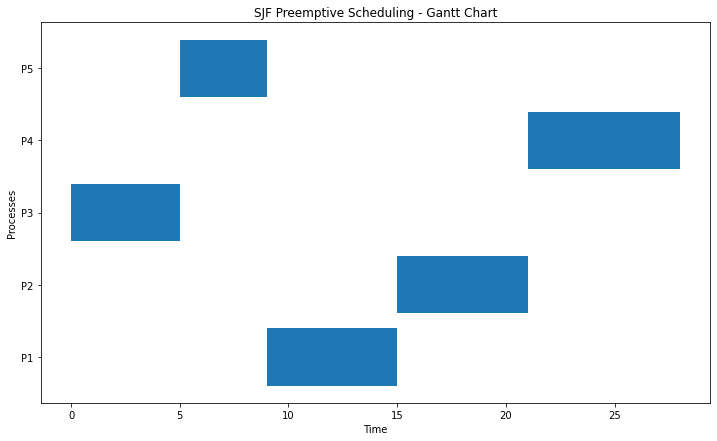

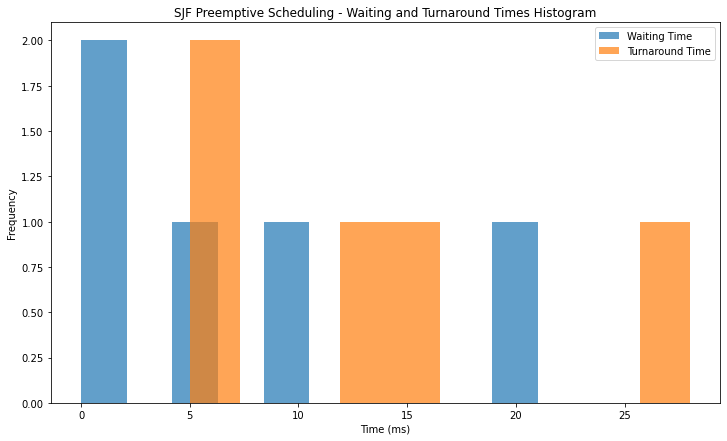

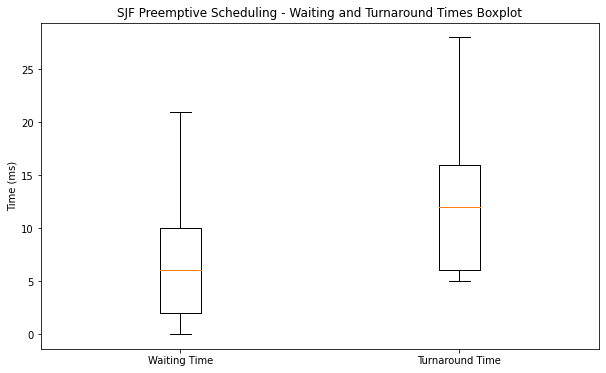

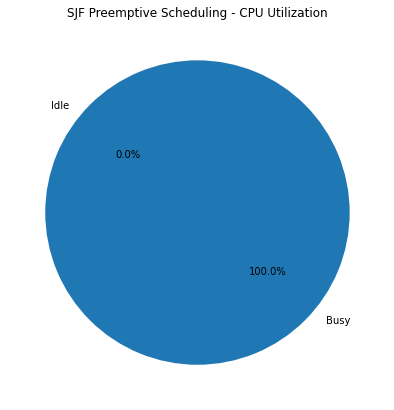

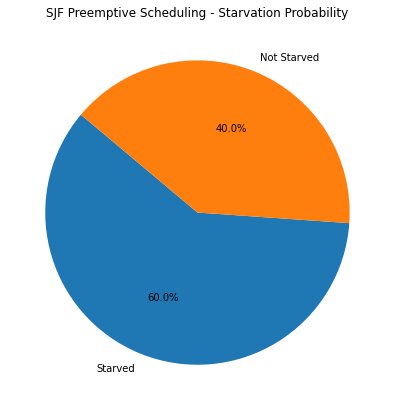

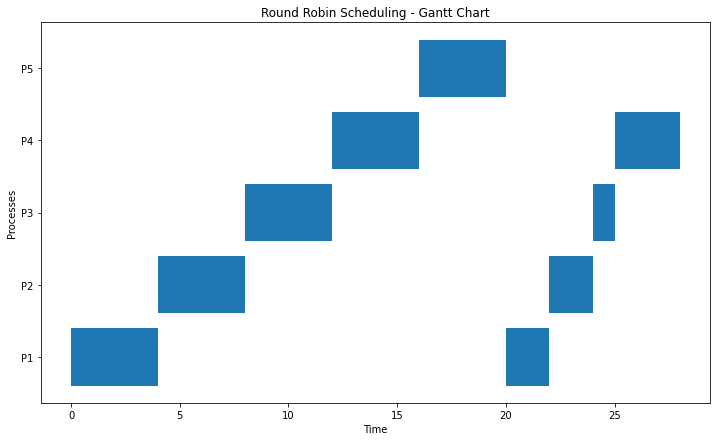

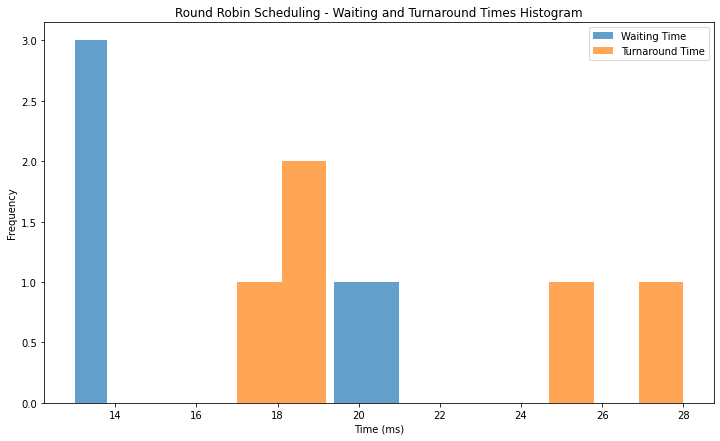

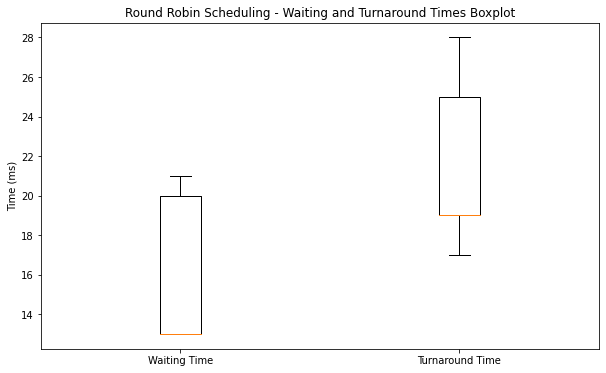

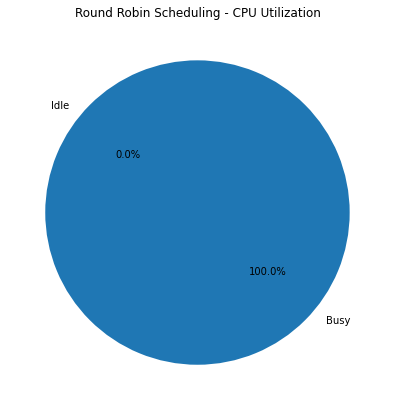

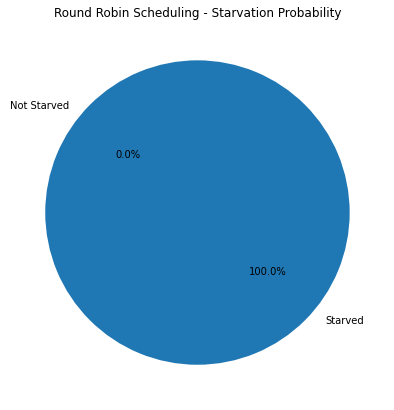

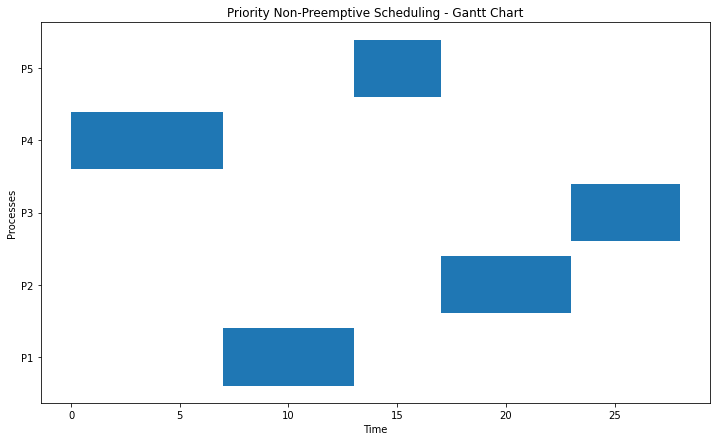

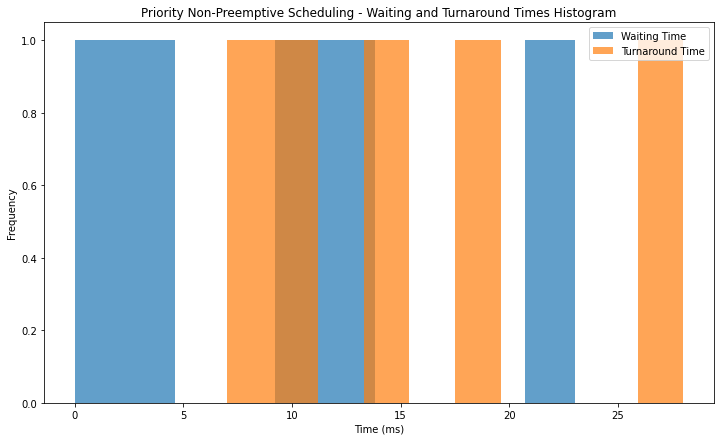

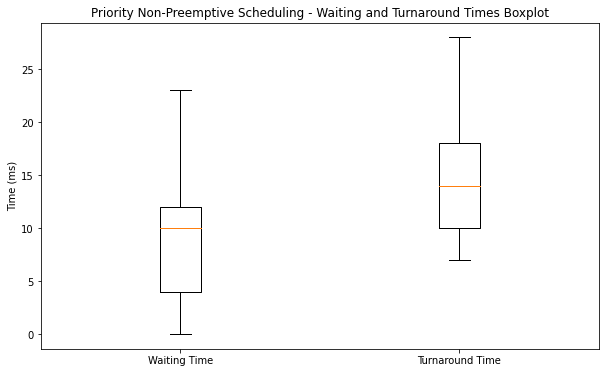

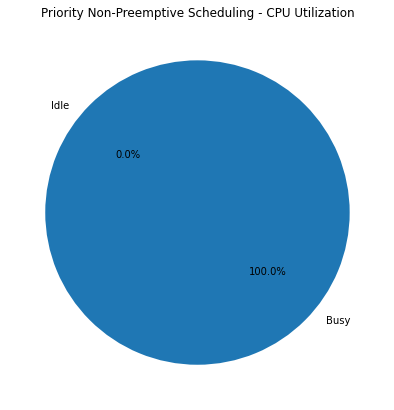

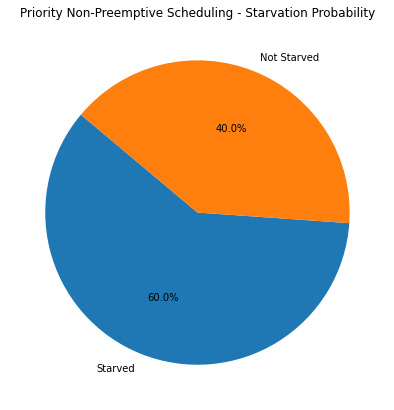

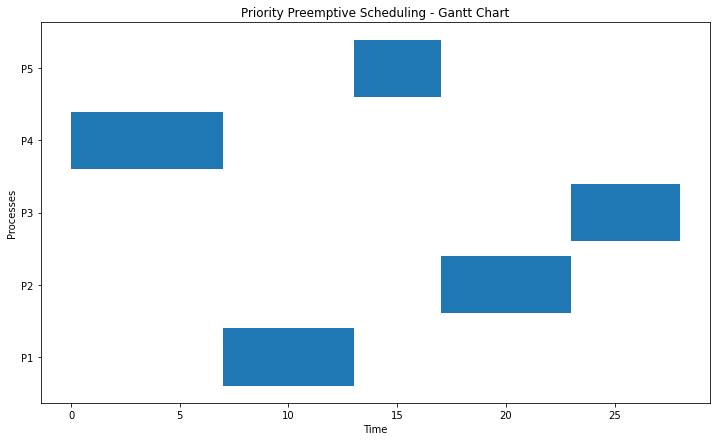

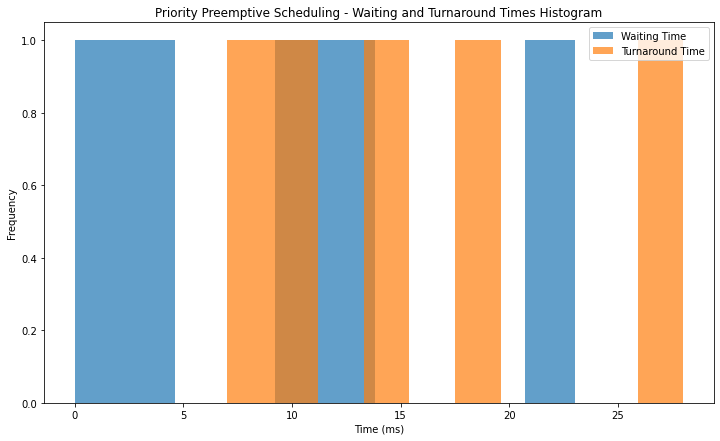

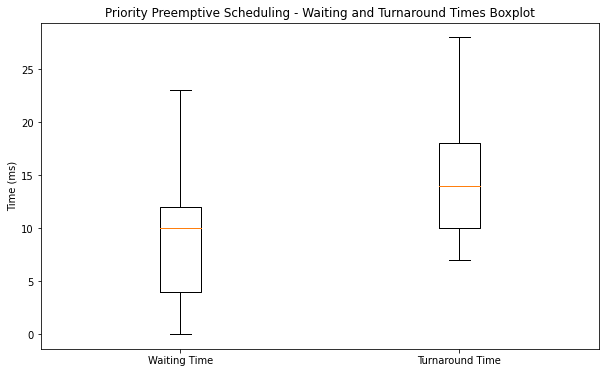

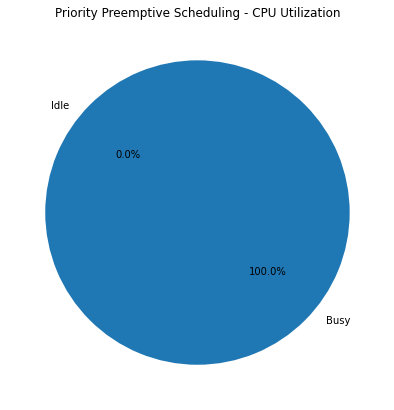

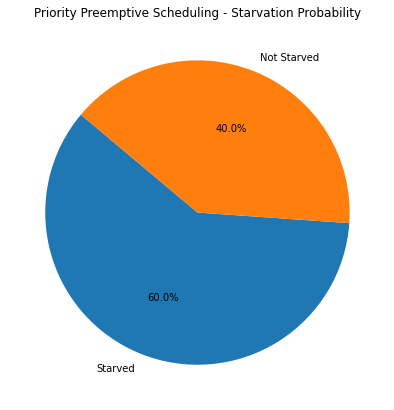

In [56]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tabulate import tabulate

# Define Process class with tracking for multiple time slices
class Process:
    def __init__(self, pid, arrival_time, burst_time, priority=5):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.priority = priority
        self.time_slices = []  # List of (start_time, duration) for time slices
        self.completion_time = 0
        self.turnaround_time = 0
        self.waiting_time = 0
        self.remaining_time = burst_time  # For preemptive algorithms

# FCFS Scheduling (Non-preemptive)
def fcfs_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    for process in processes:
        if current_time < process.arrival_time:
            current_time = process.arrival_time
        process.time_slices.append((current_time, process.burst_time))
        process.waiting_time = current_time - process.arrival_time
        process.completion_time = current_time + process.burst_time
        process.turnaround_time = process.completion_time - process.arrival_time
        current_time += process.burst_time

# SJF Scheduling (Non-preemptive)
def sjf_scheduling(processes):
    processes.sort(key=lambda x: (x.arrival_time, x.burst_time))
    current_time = 0
    completed = 0
    n = len(processes)
    ready_queue = []
    while completed < n:
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.burst_time)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            current_process.time_slices.append((current_time, current_process.burst_time))
            current_process.waiting_time = current_time - current_process.arrival_time
            current_process.completion_time = current_time + current_process.burst_time
            current_process.turnaround_time = current_process.burst_time + current_process.waiting_time
            current_time += current_process.burst_time
            completed += 1
        else:
            current_time += 1

# SJF Scheduling (Preemptive)
def sjf_preemptive_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    n = len(processes)
    ready_queue = []
    while completed < n:
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.remaining_time > 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.remaining_time)
            current_process = ready_queue[0]
            current_process.time_slices.append((current_time, 1))
            current_time += 1
            current_process.remaining_time -= 1
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                completed += 1
                ready_queue.pop(0)
        else:
            current_time += 1

# Round Robin Scheduling (Preemptive)
def round_robin_scheduling(processes, time_quantum=4):
    current_time = 0
    queue = processes[:]
    for process in queue:
        process.remaining_time = process.burst_time
    while queue:
        process = queue.pop(0)
        if process.remaining_time > 0:
            time_slice = min(time_quantum, process.remaining_time)
            process.time_slices.append((current_time, time_slice))
            current_time += time_slice
            process.remaining_time -= time_slice
            if process.remaining_time > 0:
                queue.append(process)
            else:
                process.completion_time = current_time
                process.turnaround_time = process.completion_time - process.arrival_time
                process.waiting_time = process.turnaround_time - process.burst_time

# Priority Scheduling (Non-preemptive)
def priority_non_preemptive_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    n = len(processes)
    ready_queue = []
    while completed < n:
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.priority)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            current_process.time_slices.append((current_time, current_process.burst_time))
            current_process.waiting_time = current_time - current_process.arrival_time
            current_process.completion_time = current_time + current_process.burst_time
            current_process.turnaround_time = current_process.burst_time + current_process.waiting_time
            current_time += current_process.burst_time
            completed += 1
        else:
            current_time += 1

# Priority Scheduling (Preemptive)
def priority_preemptive_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    n = len(processes)
    ready_queue = []
    while completed < n:
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.remaining_time > 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: (x.priority, x.arrival_time))
            current_process = ready_queue[0]
            time_slice = 1
            current_process.time_slices.append((current_time, time_slice))
            current_time += time_slice
            current_process.remaining_time -= time_slice
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                completed += 1
                ready_queue.pop(0)
        else:
            current_time += 1

# Visualization Functions (Enlarged)
def gantt_chart(processes, title="Gantt Chart"):
    fig, ax = plt.subplots(figsize=(12, 7))
    for p in processes:
        for (start_time, duration) in p.time_slices:
            ax.broken_barh([(start_time, duration)], (p.pid - 0.4, 0.8), facecolors=('tab:blue'))
    ax.set_yticks([p.pid for p in processes])
    ax.set_yticklabels([f'P{p.pid}' for p in processes])
    ax.set_xlabel('Time')
    ax.set_ylabel('Processes')
    ax.set_title(title)
    plt.show()

def waiting_turnaround_histogram(waiting_times, turnaround_times, title="Waiting and Turnaround Times Histogram"):
    plt.figure(figsize=(12, 7))
    plt.hist(waiting_times, bins=10, alpha=0.7, label="Waiting Time")
    plt.hist(turnaround_times, bins=10, alpha=0.7, label="Turnaround Time")
    plt.xlabel("Time (ms)")
    plt.ylabel("Frequency")
    plt.title(title)
    plt.legend()
    plt.show()

def waiting_turnaround_boxplot(waiting_times, turnaround_times, title="Boxplot of Waiting and Turnaround Times"):
    data = [waiting_times, turnaround_times]
    plt.figure(figsize=(10, 6))
    plt.boxplot(data, labels=["Waiting Time", "Turnaround Time"])
    plt.title(title)
    plt.ylabel("Time (ms)")
    plt.show()

def cpu_utilization(processes, total_time, title="CPU Utilization"):
    busy_time = sum(p.burst_time for p in processes)
    if total_time == 0:  # Prevent division by zero
        print(f"Warning: {title} - Total time is zero, unable to calculate CPU Utilization.")
        return
    idle_time = total_time - busy_time
    utilization = (busy_time / total_time) * 100
    plt.figure(figsize=(7, 7))
    plt.pie([utilization, 100 - utilization], labels=["Busy", "Idle"], autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

def starvation_probability(processes, threshold=5, title="Starvation Probability"):
    starved = [1 if p.waiting_time > threshold else 0 for p in processes]
    probability = sum(starved) / len(processes) * 100
    plt.figure(figsize=(7, 7))
    plt.pie([probability, 100 - probability], labels=["Starved", "Not Starved"], autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.show()

# Main Execution Function for Visualization and Data Display
def visualize_all(processes, scheduling_function, title="Scheduling Algorithm Analysis", **kwargs):
    # Run the scheduling algorithm
    scheduling_function(processes, **kwargs)
    waiting_times = [p.waiting_time for p in processes]
    turnaround_times = [p.turnaround_time for p in processes]
    total_time = max(p.completion_time for p in processes) if processes else 0

    # Gantt Chart
    gantt_chart(processes, title=f"{title} - Gantt Chart")

    # Histogram of Waiting and Turnaround Times
    waiting_turnaround_histogram(waiting_times, turnaround_times, title=f"{title} - Waiting and Turnaround Times Histogram")

    # Boxplot of Waiting and Turnaround Times
    waiting_turnaround_boxplot(waiting_times, turnaround_times, title=f"{title} - Waiting and Turnaround Times Boxplot")

    # CPU Utilization
    cpu_utilization(processes, total_time, title=f"{title} - CPU Utilization")

    # Starvation Probability
    starvation_probability(processes, title=f"{title} - Starvation Probability")

# Example usage with different scheduling algorithms
if __name__ == "__main__":
    # Generate random processes for testing
    processes = [Process(pid=i+1, arrival_time=random.randint(0, 5), burst_time=random.randint(1, 10), priority=random.randint(1, 5)) for i in range(5)]
    
    # Test FCFS Scheduling
    visualize_all([Process(pid=p.pid, arrival_time=p.arrival_time, burst_time=p.burst_time, priority=p.priority) for p in processes], fcfs_scheduling, title="FCFS Scheduling")
    
    # Test SJF Non-Preemptive Scheduling
    visualize_all([Process(pid=p.pid, arrival_time=p.arrival_time, burst_time=p.burst_time, priority=p.priority) for p in processes], sjf_scheduling, title="SJF Non-Preemptive Scheduling")
    
    # Test SJF Preemptive Scheduling
    visualize_all([Process(pid=p.pid, arrival_time=p.arrival_time, burst_time=p.burst_time, priority=p.priority) for p in processes], sjf_preemptive_scheduling, title="SJF Preemptive Scheduling")
    
    # Test Round Robin Scheduling
    visualize_all([Process(pid=p.pid, arrival_time=p.arrival_time, burst_time=p.burst_time, priority=p.priority) for p in processes], round_robin_scheduling, title="Round Robin Scheduling", time_quantum=4)
    
    # Test Priority Non-Preemptive Scheduling
    visualize_all([Process(pid=p.pid, arrival_time=p.arrival_time, burst_time=p.burst_time, priority=p.priority) for p in processes], priority_non_preemptive_scheduling, title="Priority Non-Preemptive Scheduling")
    
    # Test Priority Preemptive Scheduling
    visualize_all([Process(pid=p.pid, arrival_time=p.arrival_time, burst_time=p.burst_time, priority=p.priority) for p in processes], priority_preemptive_scheduling, title="Priority Preemptive Scheduling")


In [48]:
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define Process class
class Process:
    def __init__(self, pid, arrival_time, burst_time, priority=5):
        self.pid = pid
        self.arrival_time = arrival_time
        self.burst_time = burst_time
        self.priority = priority
        self.completion_time = 0
        self.turnaround_time = 0
        self.waiting_time = 0
        self.remaining_time = burst_time

# FCFS Scheduling Function
def fcfs_scheduling(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    for process in processes:
        if current_time < process.arrival_time:
            current_time = process.arrival_time
        process.waiting_time = current_time - process.arrival_time
        process.completion_time = current_time + process.burst_time
        process.turnaround_time = process.burst_time + process.waiting_time
        current_time += process.burst_time
        total_waiting_time += process.waiting_time
        total_turnaround_time += process.turnaround_time
    return total_waiting_time / len(processes), total_turnaround_time / len(processes)

# SJF Non-Preemptive Scheduling Function
def sjf_non_preemptive(processes):
    processes.sort(key=lambda x: (x.arrival_time, x.burst_time))
    current_time = 0
    completed = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    ready_queue = []
    while completed < len(processes):
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.burst_time)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            current_process.waiting_time = current_time - current_process.arrival_time
            current_process.completion_time = current_time + current_process.burst_time
            current_process.turnaround_time = current_process.burst_time + current_process.waiting_time
            current_time += current_process.burst_time
            completed += 1
            total_waiting_time += current_process.waiting_time
            total_turnaround_time += current_process.turnaround_time
        else:
            current_time += 1
    return total_waiting_time / len(processes), total_turnaround_time / len(processes)

# SJF Preemptive Scheduling Function (Shortest Remaining Time First)
def sjf_preemptive(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    ready_queue = []
    while completed < len(processes):
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.remaining_time > 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.remaining_time)
            current_process = ready_queue[0]
            current_process.remaining_time -= 1
            current_time += 1
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                total_waiting_time += current_process.waiting_time
                total_turnaround_time += current_process.turnaround_time
                ready_queue.pop(0)
                completed += 1
        else:
            current_time += 1
    return total_waiting_time / len(processes), total_turnaround_time / len(processes)

# Priority Non-Preemptive Scheduling Function
def priority_non_preemptive(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    ready_queue = []
    while completed < len(processes):
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.completion_time == 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.priority)
            current_process = ready_queue.pop(0)
            if current_time < current_process.arrival_time:
                current_time = current_process.arrival_time
            current_process.waiting_time = current_time - current_process.arrival_time
            current_process.completion_time = current_time + current_process.burst_time
            current_process.turnaround_time = current_process.burst_time + current_process.waiting_time
            current_time += current_process.burst_time
            completed += 1
            total_waiting_time += current_process.waiting_time
            total_turnaround_time += current_process.turnaround_time
        else:
            current_time += 1
    return total_waiting_time / len(processes), total_turnaround_time / len(processes)

# Priority Preemptive Scheduling Function
def priority_preemptive(processes):
    processes.sort(key=lambda x: x.arrival_time)
    current_time = 0
    completed = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    ready_queue = []
    while completed < len(processes):
        for process in processes:
            if process.arrival_time <= current_time and process not in ready_queue and process.remaining_time > 0:
                ready_queue.append(process)
        if ready_queue:
            ready_queue.sort(key=lambda x: x.priority)
            current_process = ready_queue[0]
            current_process.remaining_time -= 1
            current_time += 1
            if current_process.remaining_time == 0:
                current_process.completion_time = current_time
                current_process.turnaround_time = current_process.completion_time - current_process.arrival_time
                current_process.waiting_time = current_process.turnaround_time - current_process.burst_time
                total_waiting_time += current_process.waiting_time
                total_turnaround_time += current_process.turnaround_time
                ready_queue.pop(0)
                completed += 1
        else:
            current_time += 1
    return total_waiting_time / len(processes), total_turnaround_time / len(processes)

# Round Robin Scheduling Function
def round_robin_scheduling(processes, time_quantum=4):
    current_time = 0
    queue = processes[:]
    for process in queue:
        process.remaining_time = process.burst_time
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(processes)
    while queue:
        process = queue.pop(0)
        if process.remaining_time <= time_quantum:
            current_time += process.remaining_time
            process.waiting_time = current_time - process.arrival_time - process.burst_time
            process.turnaround_time = current_time - process.arrival_time
            total_waiting_time += process.waiting_time
            total_turnaround_time += process.turnaround_time
        else:
            current_time += time_quantum
            process.remaining_time -= time_quantum
            queue.append(process)
    return total_waiting_time / n, total_turnaround_time / n
    

# Multilevel Queue Scheduling Function
def multilevel_queue_scheduling(processes, time_quantum=4):
    high_priority = [p for p in processes if p.priority <= 3]
    low_priority = [p for p in processes if p.priority > 3]
    total_waiting_time, total_turnaround_time = 0, 0
    n = len(processes)
    if high_priority:
        rr_wait, rr_turnaround = round_robin_scheduling(high_priority, time_quantum)
        total_waiting_time += rr_wait * len(high_priority)
        total_turnaround_time += rr_turnaround * len(high_priority)
    if low_priority:
        fcfs_wait, fcfs_turnaround = fcfs_scheduling(low_priority)
        total_waiting_time += fcfs_wait * len(low_priority)
        total_turnaround_time += fcfs_turnaround * len(low_priority)
    return total_waiting_time / n, total_turnaround_time / n

# Multilevel Feedback Queue Scheduling Function
def multilevel_feedback_queue_scheduling(processes, time_quantum=4, num_queues=3):
    queues = [[] for _ in range(num_queues)]
    current_time = 0
    total_waiting_time = 0
    total_turnaround_time = 0
    n = len(processes)
    for process in processes:
        process.remaining_time = process.burst_time
        queues[0].append(process)
    for i in range(num_queues):
        while queues[i]:
            process = queues[i].pop(0)
            quantum = time_quantum * (2 ** i)
            if process.remaining_time > quantum:
                current_time += quantum
                process.remaining_time -= quantum
                if i < num_queues - 1:
                    queues[i + 1].append(process)
                else:
                    queues[i].append(process)
            else:
                current_time += process.remaining_time
                process.waiting_time = current_time - process.arrival_time - process.burst_time
                process.turnaround_time = current_time - process.arrival_time
                total_waiting_time += process.waiting_time
                total_turnaround_time += process.turnaround_time
    return total_waiting_time / n, total_turnaround_time / n
    

# Process generation
def generate_random_processes(num_processes):
    return [Process(pid=i+1, arrival_time=random.randint(0, 10), burst_time=random.randint(1, 10), priority=random.randint(1, 5)) for i in range(num_processes)]

# Run simulations with extra versions of algorithms
def run_large_scale_simulation(num_simulations=1000, num_processes=10, time_quantum=4):
    algorithms = [
        ("FCFS", fcfs_scheduling),
        ("SJF Non-Preemptive", sjf_non_preemptive),
        ("SJF Preemptive", sjf_preemptive),
        ("Round Robin", lambda p: round_robin_scheduling(p, time_quantum)),
        ("Priority Non-Preemptive", priority_non_preemptive),
        ("Priority Preemptive", priority_preemptive),
        ("MLQ", lambda p: multilevel_queue_scheduling(p, time_quantum)),
        ("MLFQ", lambda p: multilevel_feedback_queue_scheduling(p, time_quantum))
    ]

    results = {algo: {"waiting_times": np.zeros(num_simulations), "turnaround_times": np.zeros(num_simulations)} for algo, _ in algorithms}

    for i in range(num_simulations):
        processes = generate_random_processes(num_processes)
        for algo, func in algorithms:
            cloned_processes = [Process(p.pid, p.arrival_time, p.burst_time, p.priority) for p in processes]
            avg_waiting, avg_turnaround = func(cloned_processes)
            results[algo]["waiting_times"][i] = avg_waiting
            results[algo]["turnaround_times"][i] = avg_turnaround

    return results

# Visualization with solid averages for all versions
def visualize_large_scale_results_with_solid_averages(results):
    colors = {
        "FCFS": "#1f77b4", "SJF Non-Preemptive": "#ff7f0e", "SJF Preemptive": "#ffbb78",
        "Round Robin": "#2ca02c", "Priority Non-Preemptive": "#d62728", "Priority Preemptive": "#ff9896",
        "MLQ": "#9467bd", "MLFQ": "#8c564b"
    }

    overall_averages = {algo: [np.mean(data["waiting_times"]), np.mean(data["turnaround_times"])] for algo, data in results.items()}

    # Plot Waiting Times
    plt.figure(figsize=(18, 24))
    plt.subplot(3, 1, 1)
    for algo, data in results.items():
        plt.plot(data["waiting_times"], label=algo, color=colors[algo], alpha=0.4)
        plt.axhline(y=overall_averages[algo][0], color=colors[algo], linestyle="-")
        plt.text(len(data["waiting_times"]) - 1, overall_averages[algo][0], 
                 f"{overall_averages[algo][0]:.2f} ms", color=colors[algo], ha="left", fontsize=9, bbox=dict(facecolor="white", edgecolor="black"))
    plt.xlabel("Simulation #")
    plt.ylabel("Average Waiting Time (ms)")
    plt.title("Average Waiting Time per Simulation")
    plt.legend()

    # Plot Turnaround Times
    plt.subplot(3, 1, 2)
    for algo, data in results.items():
        plt.plot(data["turnaround_times"], label=algo, color=colors[algo], alpha=0.4)
        plt.axhline(y=overall_averages[algo][1], color=colors[algo], linestyle="-")
        plt.text(len(data["turnaround_times"]) - 1, overall_averages[algo][1], 
                 f"{overall_averages[algo][1]:.2f} ms", color=colors[algo], ha="left", fontsize=9, bbox=dict(facecolor="white", edgecolor="black"))
    plt.xlabel("Simulation #")
    plt.ylabel("Average Turnaround Time (ms)")
    plt.title("Average Turnaround Time per Simulation")
    plt.legend()

    # Bar chart for overall averages
    plt.subplot(3, 1, 3)
    labels = list(overall_averages.keys())
    waiting_times = [overall_averages[algo][0] for algo in labels]
    turnaround_times = [overall_averages[algo][1] for algo in labels]
    bar_width = 0.35
    index = np.arange(len(labels))
    plt.bar(index, waiting_times, bar_width, label="Average Waiting Time")
    plt.bar(index + bar_width, turnaround_times, bar_width, label="Average Turnaround Time")
    plt.xlabel("Scheduling Algorithms")
    plt.ylabel("Average Time (ms)")
    plt.title("Overall Average Waiting and Turnaround Times")
    plt.xticks(index + bar_width / 2, labels)

    for i, v in enumerate(waiting_times):
        plt.text(i, v + 0.1, f"{v:.2f} ms", ha="center", va="bottom", fontsize=9)
    for i, v in enumerate(turnaround_times):
        plt.text(i + bar_width, v + 0.1, f"{v:.2f} ms", ha="center", va="bottom", fontsize=9)

    plt.legend()
    plt.tight_layout()
    plt.show()

    # Display summary table
    summary_data = {
        "Algorithm": labels,
        "Average Waiting Time (ms)": [round(value, 2) for value in waiting_times],
        "Average Turnaround Time (ms)": [round(value, 2) for value in turnaround_times]
    }
    summary_df = pd.DataFrame(summary_data)
    print("\nSummary of Average Waiting and Turnaround Times:")
    print(summary_df.to_markdown(index=False, tablefmt="grid"))




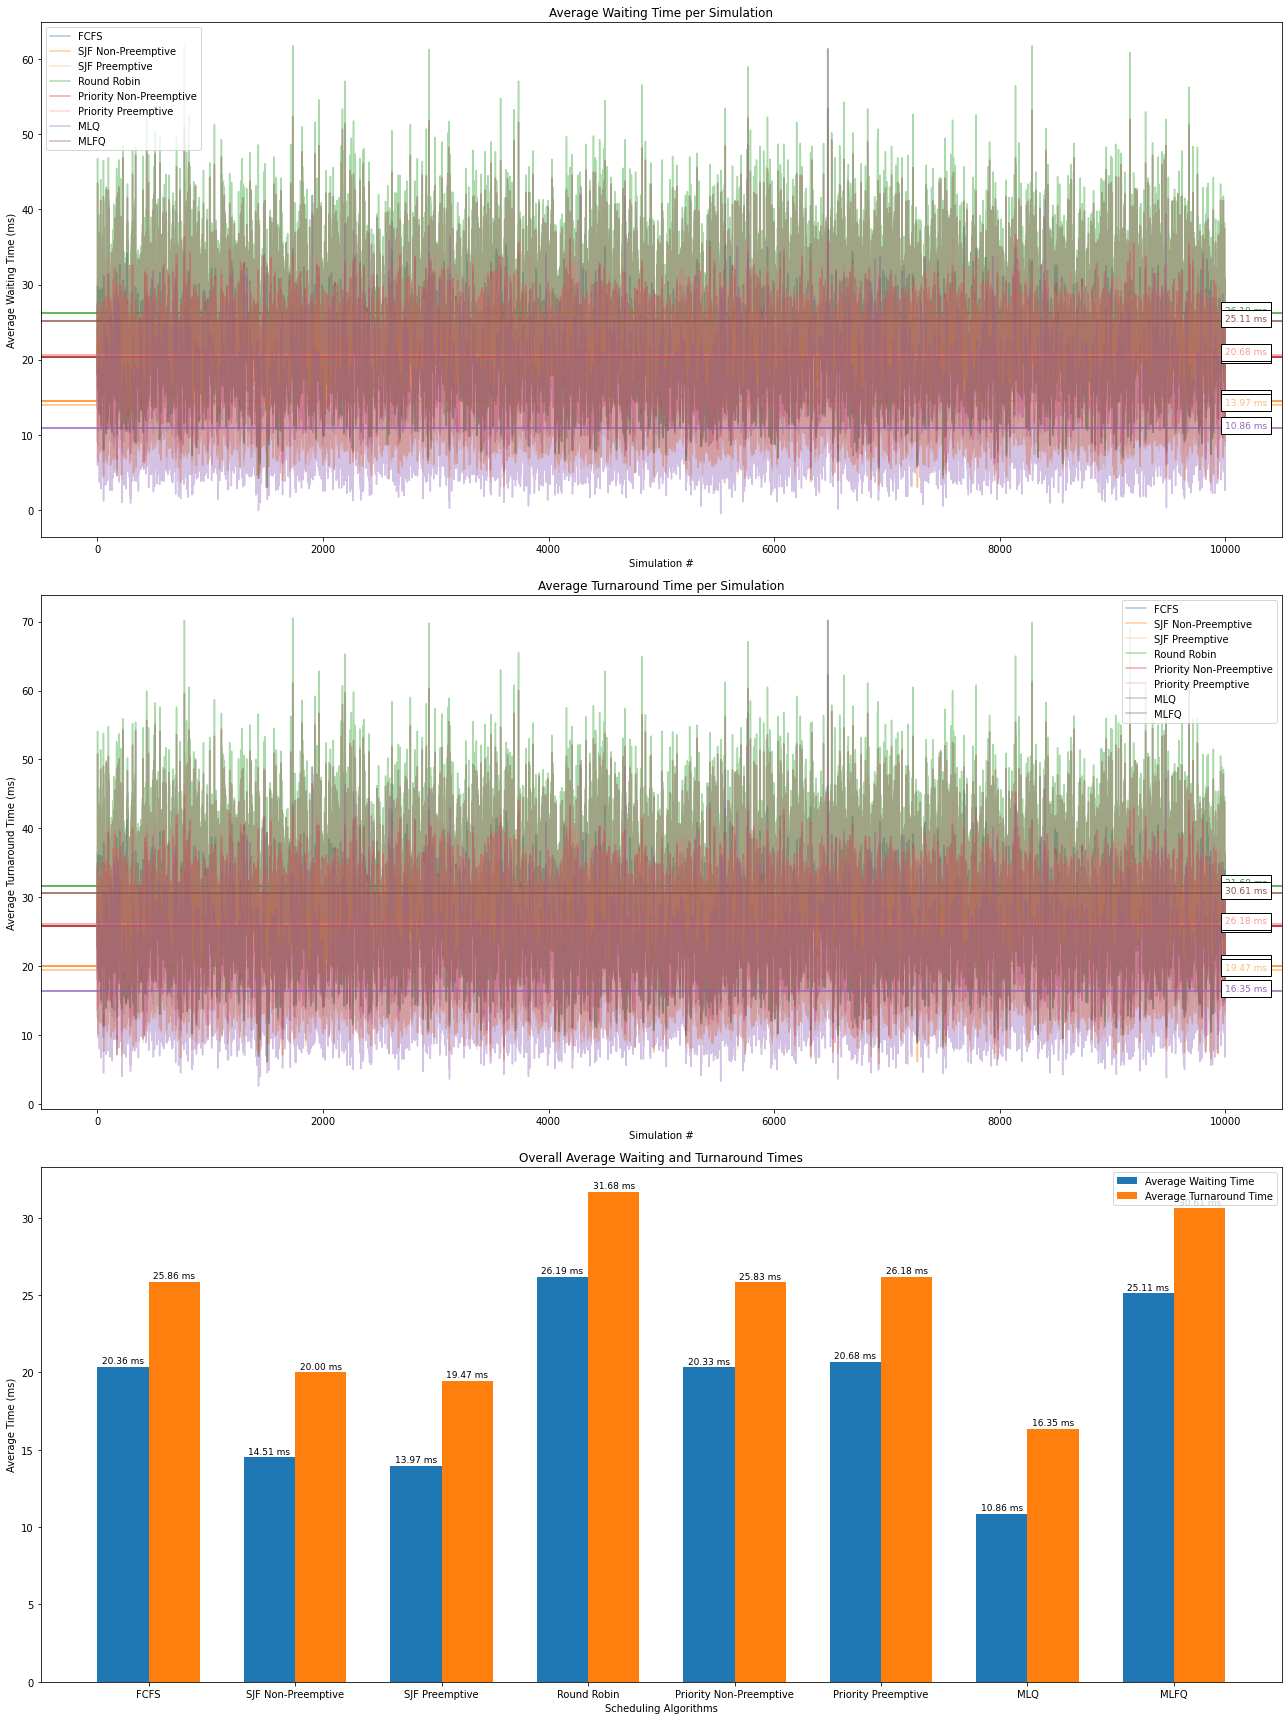


Summary of Average Waiting and Turnaround Times:
+-------------------------+-----------------------------+--------------------------------+
| Algorithm               |   Average Waiting Time (ms) |   Average Turnaround Time (ms) |
+=========================+=============================+================================+
| FCFS                    |                       20.36 |                          25.86 |
+-------------------------+-----------------------------+--------------------------------+
| SJF Non-Preemptive      |                       14.51 |                          20    |
+-------------------------+-----------------------------+--------------------------------+
| SJF Preemptive          |                       13.97 |                          19.47 |
+-------------------------+-----------------------------+--------------------------------+
| Round Robin             |                       26.19 |                          31.68 |
+-------------------------+-------------

In [49]:
# 10 Processes

# Main execution to run simulations and visualize
if __name__ == "__main__":
    results = run_large_scale_simulation(num_simulations=10000, num_processes=10)
    visualize_large_scale_results_with_solid_averages(results)

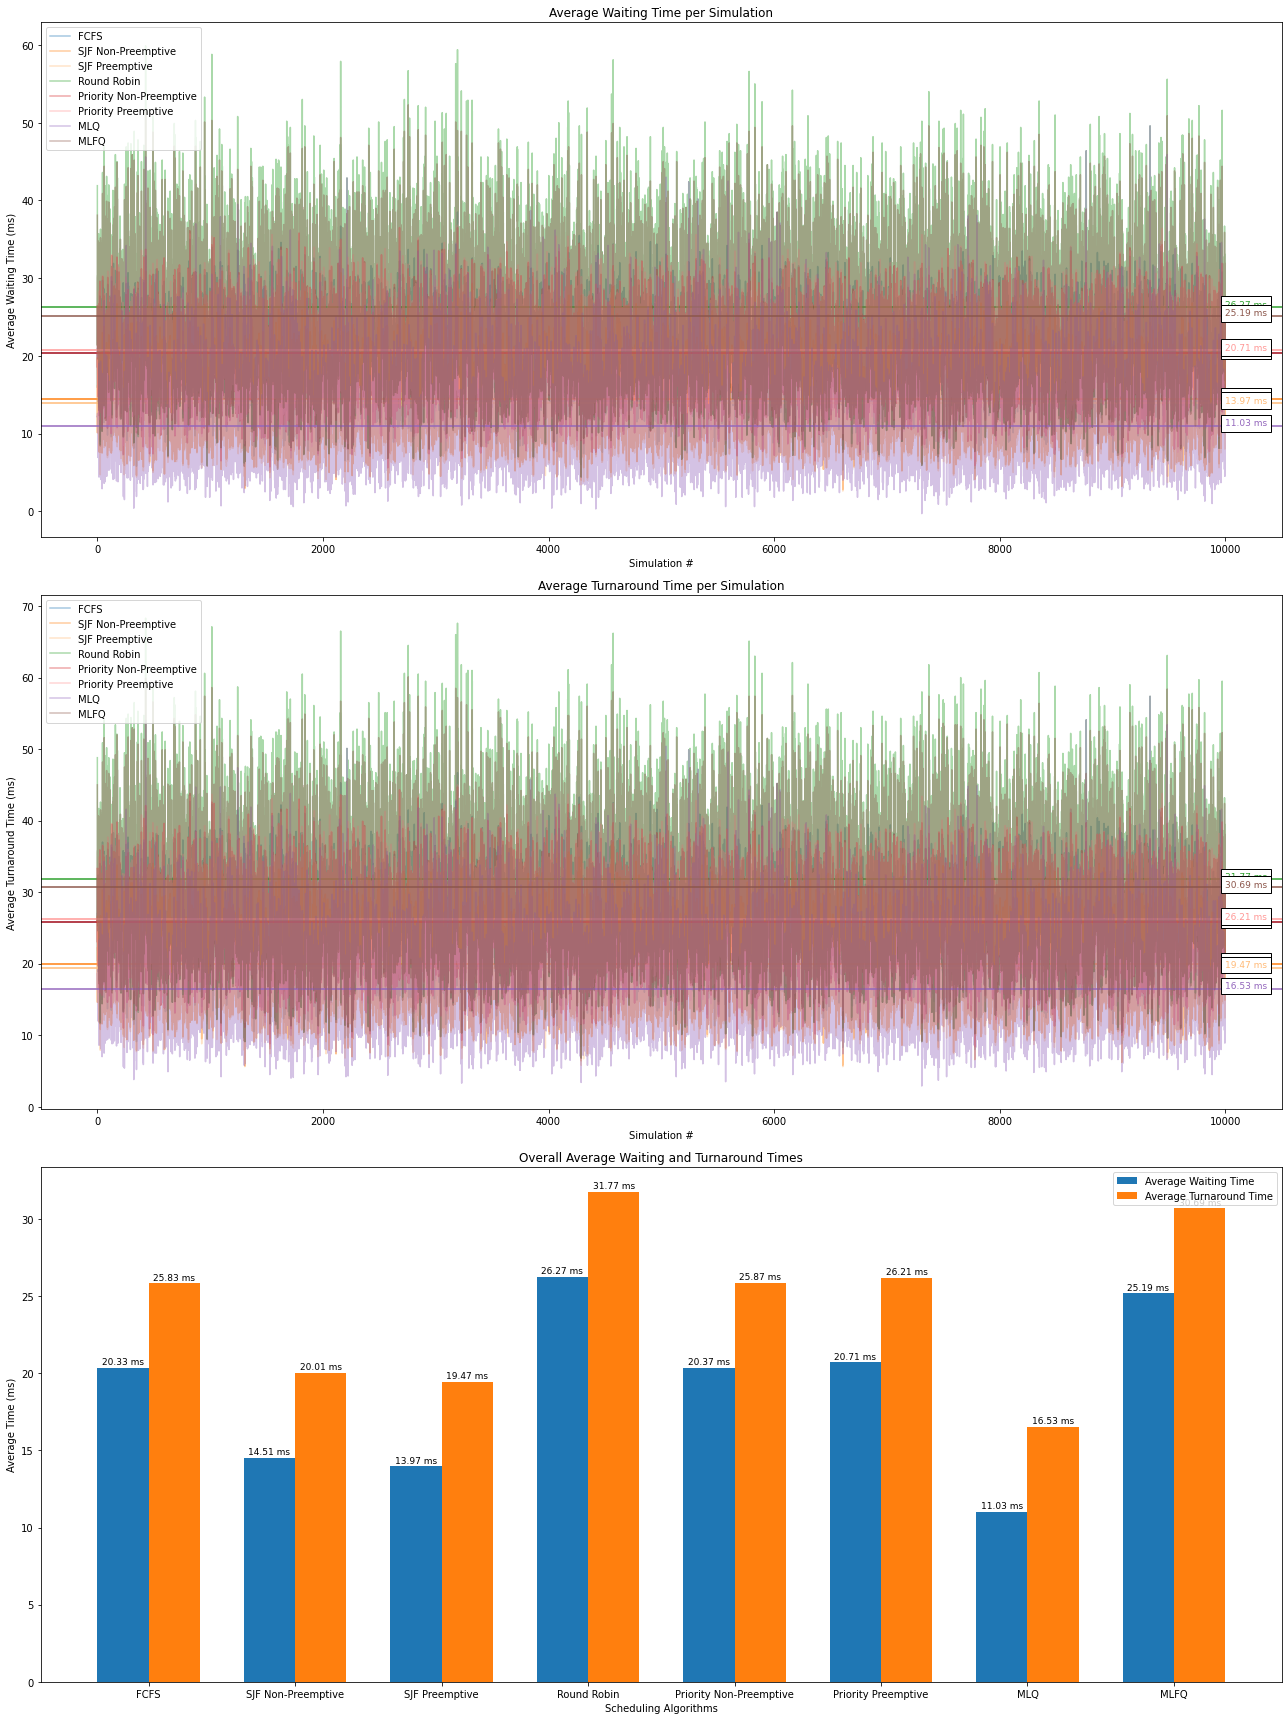


Summary of Average Waiting and Turnaround Times:
+-------------------------+-----------------------------+--------------------------------+
| Algorithm               |   Average Waiting Time (ms) |   Average Turnaround Time (ms) |
+=========================+=============================+================================+
| FCFS                    |                       20.33 |                          25.83 |
+-------------------------+-----------------------------+--------------------------------+
| SJF Non-Preemptive      |                       14.51 |                          20.01 |
+-------------------------+-----------------------------+--------------------------------+
| SJF Preemptive          |                       13.97 |                          19.47 |
+-------------------------+-----------------------------+--------------------------------+
| Round Robin             |                       26.27 |                          31.77 |
+-------------------------+-------------

In [ ]:
# 100 Processes

# Main execution to run simulations and visualize
if __name__ == "__main__":
    results = run_large_scale_simulation(num_simulations=10000, num_processes=100)
    visualize_large_scale_results_with_solid_averages(results)